In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from green_mood_tracker.training_data import get_raw_data_notebook
from green_mood_tracker.data_cleaning import clean

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## download and clean data

In [2]:
%%time
raw_data = get_raw_data_notebook(True)
raw_data.head()

c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sentiment140_final['source'] = 'sentiment140'
c:\users\cleme\.venvs\lewagon\lib\site-packages\green_mood_tracker\training_data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  complete_data_binary['polarity'] = complete_data_binary.polarity.map({4:1,0:0})


Wall time: 56.1 s


,id,text,polarity,source
0,1467933112,the angel is going to miss the athlete this we...,0,sts_gold
1,2323395086,It looks as though Shaq is getting traded to C...,0,sts_gold
2,1467968979,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH,0,sts_gold
3,1990283756,drinking a McDonalds coffee and not understand...,0,sts_gold
4,1988884918,So dissapointed Taylor Swift doesnt have a Twi...,0,sts_gold


In [3]:
raw_data.shape

(1620501, 4)

## Explore data

In [4]:
raw_data.source.value_counts()

sentiment140              1600000
kaggle_sentiment_train      16363
kaggle_sentiment_test        2104
sts_gold                     2034
Name: source, dtype: int64

In [5]:
raw_data.polarity.value_counts()

1    810317
0    810184
Name: polarity, dtype: int64

## sample data

In [6]:
data_sample = raw_data.sample(n=25_000,random_state=0).reset_index()

In [7]:
%%time
data_sample_clean = clean(data_sample,'text')
data_sample_clean.head()

Wall time: 58.5 s


,index,id,text,polarity,source
0,336834,2014083611,pinch even fought amma hate new goatee sd look...,0,sentiment140
1,622734,2229303528,didnt even get try week,0,sentiment140
2,1016867,1881768019,giving jack quick hair cut,1,sentiment140
3,1090541,1969804803,pirate game sat sun work monday tuesthur work ...,1,sentiment140
4,947493,1823084268,fun night,1,sentiment140


## split data Train/Test

In [18]:
from sklearn.model_selection import train_test_split

X = data_sample_clean.text
y = data_sample_clean.polarity

In [19]:
sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

## tokenize

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(sentence_train)
word_to_id = tk.word_index
id_to_word = {value:key for key,value in word_to_id.items()}
sentences_token_train = tk.texts_to_sequences(sentence_train)
sentences_token_test = tk.texts_to_sequences(sentence_test)

vocab_size=len(word_to_id)

## pad data

In [21]:
def generate_data(X_train,X_test):
    
    # YOUR CODE HERE
    X_train_pad = pad_sequences(X_train, dtype = 'float32',padding='post')
    X__test_pad = pad_sequences(X_test, dtype = 'float32',padding='post')
    
    return X_train_pad,X__test_pad

X_train_pad, X_test_pad = generate_data(sentences_token_train,sentences_token_test)

In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

## build lstm model

In [23]:
def init_model(vocab_size):
    
    # YOUR CODE HERE
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=100, mask_zero=True))
    model.add(layers.GRU(units=13, activation='tanh')) 
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss= 'binary_crossentropy', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [24]:
%%time
model_emb = init_model(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_emb = model_emb.fit(X_train_pad, y_train,
          validation_split= 2/7,
          epochs=100, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/100
391/391 [==============================] - 13s 33ms/step - loss: 0.5865 - accuracy: 0.6870 - val_loss: 0.5307 - val_accuracy: 0.7328
Epoch 2/100
391/391 [==============================] - 11s 27ms/step - loss: 0.4504 - accuracy: 0.7957 - val_loss: 0.5349 - val_accuracy: 0.7338
Epoch 3/100
391/391 [==============================] - 11s 27ms/step - loss: 0.3994 - accuracy: 0.8254 - val_loss: 0.5453 - val_accuracy: 0.7302
Epoch 4/100
391/391 [==============================] - 10s 27ms/step - loss: 0.3630 - accuracy: 0.8450 - val_loss: 0.5741 - val_accuracy: 0.7292
Epoch 5/100
391/391 [==============================] - 10s 26ms/step - loss: 0.3258 - accuracy: 0.8641 - val_loss: 0.5924 - val_accuracy: 0.7246
Epoch 6/100
391/391 [==============================] - 11s 28ms/step - loss: 0.2835 - accuracy: 0.8859 - val_loss: 0.6166 - val_accuracy: 0.7194
Epoch 7/100
391/391 [==============================] - 10s 25ms/step - loss: 0.2460 - accuracy: 0.9034 - val_loss: 0.6657 - val_ac

235/235 [==============================] - 1s 3ms/step - loss: 0.5321 - accuracy: 0.7429
accuracy 0.7429333329200745


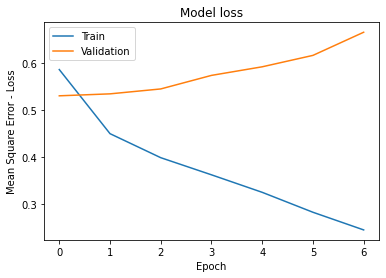

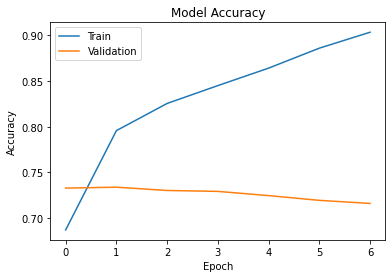

In [25]:
print('accuracy', model_emb.evaluate(X_test_pad,y_test)[1])
plot_loss(history_emb)

## build convolutional model

In [26]:
def generate_data_cnn(X_train,X_test):
    
    # YOUR CODE HERE
    X_train_pad = pad_sequences(X_train, dtype = 'float32',padding='post',maxlen=50)
    X__test_pad = pad_sequences(X_test, dtype = 'float32',padding='post',maxlen=50)
    
    return X_train_pad,X__test_pad

X_train_pad_cnn, X_test_pad_cnn = generate_data_cnn(sentences_token_train,sentences_token_test)

In [27]:
def init_model_cnn(vocab_size):
    
    model = Sequential()

    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=100,input_length=50, mask_zero=True))
    model.add(layers.Conv1D(16,kernel_size = 5, activation='relu')) 
    model.add(layers.Flatten()) 
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss= 'binary_crossentropy',  
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [28]:
%%time
model_cnn = init_model_cnn(vocab_size)

es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history_cnn = model_cnn.fit(X_train_pad_cnn, y_train,
          validation_split= 2/7,
          epochs=100, 
          batch_size=32, 
          verbose=1,
          use_multiprocessing=True,
          callbacks = [es])

Epoch 1/100
391/391 [==============================] - 10s 26ms/step - loss: 0.6291 - accuracy: 0.6371 - val_loss: 0.5428 - val_accuracy: 0.7318
Epoch 2/100
391/391 [==============================] - 10s 26ms/step - loss: 0.4654 - accuracy: 0.7843 - val_loss: 0.5568 - val_accuracy: 0.7238
Epoch 3/100
391/391 [==============================] - 10s 25ms/step - loss: 0.3865 - accuracy: 0.8326 - val_loss: 0.5617 - val_accuracy: 0.7280
Epoch 4/100
391/391 [==============================] - 9s 24ms/step - loss: 0.3065 - accuracy: 0.8764 - val_loss: 0.5991 - val_accuracy: 0.7202
Epoch 5/100
391/391 [==============================] - 9s 24ms/step - loss: 0.2245 - accuracy: 0.9152 - val_loss: 0.6911 - val_accuracy: 0.6950
Epoch 6/100
391/391 [==============================] - 10s 24ms/step - loss: 0.1597 - accuracy: 0.9394 - val_loss: 0.7840 - val_accuracy: 0.6904
Wall time: 59.9 s


235/235 [==============================] - 1s 3ms/step - loss: 0.5426 - accuracy: 0.7329
accuracy 0.7329333424568176


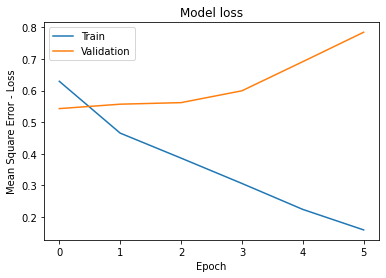

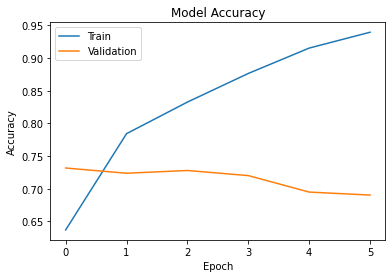

In [29]:
print('accuracy', model_cnn.evaluate(X_test_pad_cnn,y_test)[1])
plot_loss(history_cnn)

In [ ]:
# job save --- not working
# import joblib

# filename = 'model_emb_binary.joblib'
# joblib.dump(model_emb, filename)

# import pickle

# filename = 'model_emb_binary.sav'
# pickle.dump(model_emb, open(filename, 'wb'))

## Evaluate

In [65]:
print('embeddings+LSTM accuracy:',model_emb.evaluate(X_test_pad,y_test))

235/235 [==============================] - 1s 5ms/step - loss: 0.5321 - accuracy: 0.7429
embeddings+LSTM accuracy: [0.5321478247642517, 0.7429333329200745]


In [66]:
print('cnn accuracy:',model_cnn.evaluate(X_test_pad_cnn,y_test))

235/235 [==============================] - 1s 5ms/step - loss: 0.5426 - accuracy: 0.7329
cnn accuracy: [0.542564332485199, 0.7329333424568176]


### Predict on London

In [73]:
import nest_asyncio
import sys
from green_mood_tracker.twint_class import TWINT
nest_asyncio.apply()

In [75]:
import sys
sys.path.insert(0, '../green_mood_tracker/')

In [ ]:
kwargs = dict(
    keywords=['nuclear'],
    cities=['London'],
    since = '2020-11-10 12:00:00',
    limit=200,
    file_path='../green_mood_tracker/data/london_nuclear.csv'
)

t = TWINT(**kwargs)

df_city = t.city_csv()

In [ ]:
! ls ../green_mood_tracker/data/

In [ ]:
csv = pd.read_csv('../green_mood_tracker/data/london_nuclear.csv')